In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from graphviz import Digraph
import random

%matplotlib inline

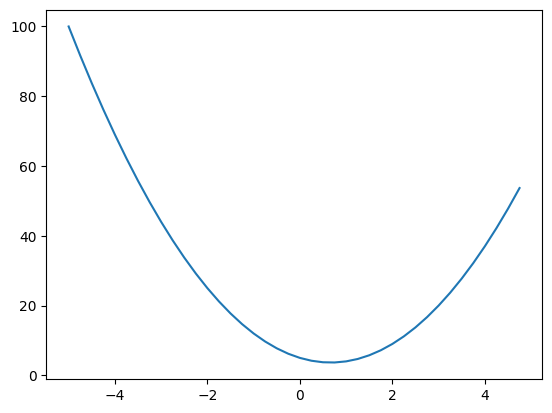

In [2]:
# an ordinary function

def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [3]:
# computing the derivative for that function at a specific point

h = 0.0001
x = 3.0
(f(x+h) - f(x))/h

14.000300000063248

In [4]:
# we can do this for a function with multiple variables as well
# here we are finding the 'partial' derivative, ie how the output is effected based on tweaking one input at a time

h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
slope = (d2-d1)/h

slope

0.9999999999976694

In [5]:
# Value Object for our neural net graph

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other) -> 'Value': # self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
    
        return out
    
    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other): # self ** other
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _backward

        return out
    
    def exp(self): # e ** self
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # becuase derivative of e^x = e^x

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __neg__(self): # -self
        return self * -1
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self):
        topo: list[Value] = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [6]:
# helper function for graphing NN

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

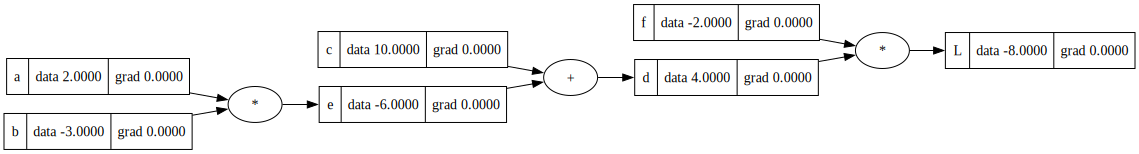

In [7]:
# manually creating the function 'L = ((a * b) + c) * f' with Value objects
# note that we want to represent intermediate states so it's all trackable, even if these aren't 'true' inputs

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2, label='f')
L = d * f; L.label = 'L'
draw_dot(L)

![Artifical Neuron](./resources/artificial-neuron.webp)

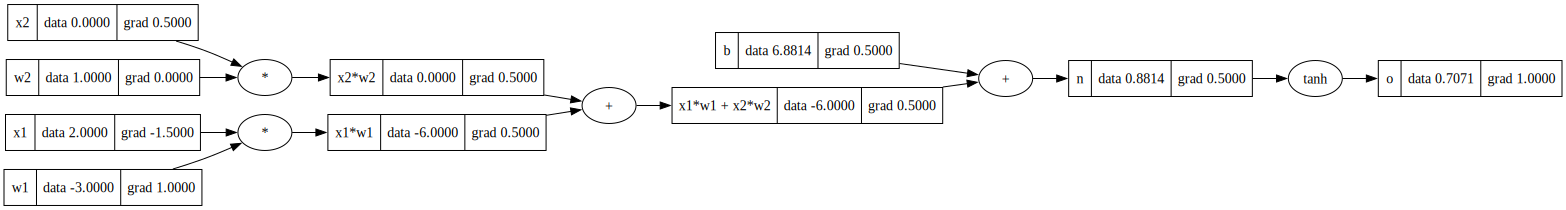

In [8]:
# Manually creatting a single neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights (synaptic strength, scales the related input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron itself, how much it wants to encourage or supress activation
# (bias was arbitrarily chosen to give us near-integer values)
b = Value(6.8813735870195432, label='b')

# computational graph for this neuron ie sum_all(xn * wn)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
sum_all_inputs = x1w1 + x2w2; sum_all_inputs.label = 'x1*w1 + x2*w2'
n = sum_all_inputs + b; n.label = 'n'

# activation function will squash the number nicely between -1 and 1 making it easy to create a decision boundary, let's say at 0
o = n.tanh(); o.label = 'o'

# backprop allows us to work backwards from the final expression to compute the gradient for each input
o.backward()

draw_dot(o)

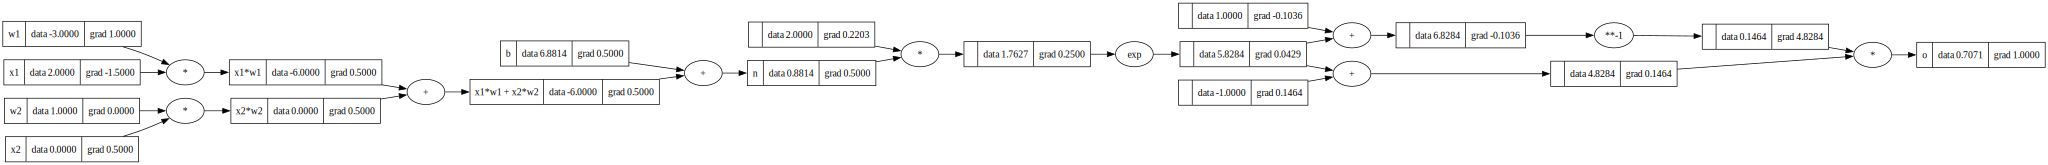

In [9]:
# same as above, but note how we were able to define tanh using more primitive operations we have now defined
# the output should be identical

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
sum_all_inputs = x1w1 + x2w2; sum_all_inputs.label = 'x1*w1 + x2*w2'
n = sum_all_inputs + b; n.label = 'n'

# let's test new ops by computing tanh explicitly
# tanh(x) = (exp(2 * x) - 1) / (exp(2 * x) + 1)
e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'

o.backward()

draw_dot(o)

In [10]:
# can do the same thing in pytorch now that we understand how it works

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


![MLP](./resources/multi-layer-perceptron.png)

In [11]:
# we built an artificial neuron using Values, so let's now make classes to represent a MLP

class Neuron:

    def __init__(self, nin):
        # list of randomized weights, based on input nin (# inputs)
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        # helper function to collect all parameters for this neuron
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [12]:
# testing a single Neuron

x = [2.0, 3.0]
n = Neuron(2)
output = n(x)

print(n.w, n.b)

print(math.tanh(2.0 * n.w[0].data + 3.0*n.w[1].data + n.b.data))

[Value(data=0.488931704505257), Value(data=0.6298358850394166)] Value(data=0.9709008308792306)
0.9990732809162801


In [13]:
# testing a layer of Neurons

x = [2.0, 3.0]
n = Layer(2, 3)

output = n(x)

output

[Value(data=0.9549545297113671),
 Value(data=-0.8098428466849071),
 Value(data=0.7209541548926206)]

In [14]:
# testing a MLP

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

output = n(x)

output

Value(data=0.31767069179091434)

In [15]:
# Batch input data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# desired targets
ys = [1.0, -1.0, -1.0, 1.0]

ypreds = [n(x) for x in xs]

# predictions for these 4 examples given our existing NN
ypreds

[Value(data=0.31767069179091434),
 Value(data=-0.7536592212363326),
 Value(data=-0.6453695538510388),
 Value(data=0.14243540071200098)]

In [16]:
# Now the question is: how do we 'tune' our NN to perform better (ypred better approx y)
# we can do this by first defining a loss function - measure how good/bad our prediction is (summed on all examples)

loss = sum((ypred-y)**2 for (y, ypred)  in zip(ys, ypreds))
loss

Value(data=1.387436859410777)

In [17]:
# running backprop to generate gradients for all the nodes in our loss function
loss.backward()

In [18]:
# arbitrary weight for testing
w = n.layers[0].neurons[0].w[0]
w_before = w.data

In [19]:
# adjust all parameters by their associated gradient
for p in n.parameters():
    p.data += -0.01 * p.grad

In [20]:
# weight is a little closer to 0 after adjusting by the gradient
print(f"w went from: {w_before} -> {w.data}, having been adjusted by grad {w.grad} scaled by a step size of 0.01")

# rerun loop
ypreds = [n(x) for x in xs]

loss = sum((ypred-y)**2 for (y, ypred)  in zip(ys, ypreds))

# ypreds should now be slightly closer to y, measured in the form of a loss function score closer to 0
loss

w went from: 0.2669930500842028 -> 0.26678044891576647, having been adjusted by grad 0.021260116843634047 scaled by a step size of 0.01


Value(data=1.0386698742283709)

In [21]:
# now let's run it iteratively to see how we can get the loss function near 0

# Batch input data
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

# desired targets
ys = [1.0, -1.0, -1.0, 1.0]

# model
n = MLP(3, [4, 4, 1])

# run iterations to see the results
for i in range(20):
    # compute ypreds
    ypreds = [n(x) for x in xs]
    # recompute the loss (it's improved)
    loss = sum((ypred-y)**2 for (y, ypred) in zip(ys, ypreds))
    # compute gradients
    loss.backward()
    # adjust params by new gradients
    for p in n.parameters():
      p.data += -0.01 * p.grad

    print(f"{i+1}: {loss}")


1: Value(data=4.383731027819015)
2: Value(data=3.9506378151744386)
3: Value(data=3.297641793341914)
4: Value(data=2.8001549900918046)
5: Value(data=2.467518759712277)
6: Value(data=1.8354484400190842)
7: Value(data=0.7691835616529081)
8: Value(data=0.24312521380502344)
9: Value(data=0.08919199363971625)
10: Value(data=0.03779340959667449)
11: Value(data=0.018478633161822935)
12: Value(data=0.010504976226572005)
13: Value(data=0.00701948134601076)
14: Value(data=0.005608072687970148)
15: Value(data=0.005424748621007263)
16: Value(data=0.0063089817663120875)
17: Value(data=0.008561417736555802)
18: Value(data=0.012949994600730078)
19: Value(data=0.020642289064791677)
20: Value(data=0.032464217611900395)


# in summary

So what did we learn? 

- We learnt that we can define a neuron like so: `activation_fn(sumall(w_i, x_i) + b)` using our Value nodes
- We can then define individual layers, and a MLP using these same nodes and feeding outputs from one layer as inputs to the next
A MLP is then defined by it's # of inputs, # of layers, and # nodes at each layer
Then, given some arbitrary input data corresponding to some arbitrary output data, we can iteratively run our model to produce predictions, calculate a loss function for how 'well' we did, run backprop to determine the gradients at each node in relation to the output (predictions), and finally adjust the weights and biases at each node (scaled by a step size) to result in a better loss function score (ie better predictions) on the next iteration. After enough iterations, our NN has 'learnt' weights and biases that effectively match the input to the expected output. if we had a validation set we could then test our trained model against it to see how it performs on data it's never seen. 